# Load and test PyOPIA default classifier
* Download the default PyOPIA classifier from Azure blob storage and test on example particle images
* This version of the PyOPIA classifier was trained on 2025-04-09
* It was trained on 11 617 images belonging to 7 classes:
  * bubble, copepod, diatom_chain, faecal_pellets, oil, oily_gas, other
* The model has weighted average f1-score of 0.91 on the example images
* Intensity normalization [0-1] was applied to some of the images in the training database, and therefore the "normalize_intensity" option should be used for the PyOPIA classifier initialization.

In [1]:
!uv pip install -q ipywidgets scikit-learn

In [2]:
import pyopia.classify
import pyopia.exampledata
import pyopia.plotting
import pyopia.statistics
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from tqdm.notebook import tqdm
np.random.seed(42)

In [ ]:
def classify_plot_class_rois(class_name, classifier, filelist):
    """Classify single-object (ROI) images and plot images in a grid with best guess class.
    
    Parameters
    ----------
    class_name: str
        Name of class ROI files belong to (e.g. 'copepod')
    classifier: pyopia.classify.Classify
        PyOPIA classifier instance
    filelist: list
        List of single-object (ROI) files

    Returns
    -------
    df_: pandas.DataFrame
        Classification info for each image
    """
    # Load single-object images (ROIs)
    roilist = [np.float64(plt.imread(f)) / 255.0 for f in filelist ]

    # Classify ROIs
    df_ = pyopia.plotting.classify_rois(roilist, classifier)
    df_ = pyopia.statistics.add_best_guesses_to_stats(df_)

    # Remove "_probability" from labels
    df_ = df_.replace("probability_", "", regex=True)
    df_.columns = df_.columns.str.replace("probability_", "", regex=True)

    # Plot
    fig, ax = pyopia.plotting.plot_classified_rois(roilist, df_, true_class=class_name)

    # Print classification info
    num_correct = (df_["best guess)"] == class_name).sum()
    frac_class = num_correct / df_.shape[1]
    print(f"Correctly identified {class_name} was {100*frac_class:.1f}% ({num_correct}/{df_.shape[1]})")
    fig.suptitle(f"Class: {class_name} ({num_correct}/{df_.shape[1]}, {100*frac_class:.1f}%)")

    return df_.style.format(precision=1, decimal=".")

## Set up PyOPIA classifier

In [4]:
model_path = pyopia.exampledata.get_example_model()
print(f"Model path: {model_path}")
classifier = pyopia.classify.Classify(model_path=model_path, normalize_intensity=True)

_, img_height, img_width, _ = classifier.model.get_config()['layers'][0]['config']['batch_shape']
class_labels = classifier.model.layers[-1].name.split('.')
print("Model image input shape:", classifier.model.input_shape)
print("Model class labels:", class_labels)

classifier.model.summary()


Model path: pyopia-default-classifier-20250409.keras
Model image input shape: (1, 64, 64, 3)
Model class labels: ['bubble', 'copepod', 'diatom_chain', 'faecal_pellets', 'oil', 'oily_gas', 'other']


Model: "PyOPIA_main_globalmaxpool"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (1, 64, 64, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (1, 64, 64, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (1, 64, 64, 32)        │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (1, 32, 32, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (1, 32, 32, 64)        │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (1, 32, 32, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (1, 32, 32, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (1, 32, 32, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (1, 32, 32, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (1, 64)                │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 512)               │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (1, 512)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bubble.copepod.diatom_chain.fa… │ (1, 7)                 │         3,591 │
│ (Dense)                         │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 611,926 (2.33 MB)

 Trainable params: 203,975 (796.78 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 407,951 (1.56 MB)

## Download and index database images and labels

In [5]:
pyopia.exampledata.get_classifier_database_from_pysilcam_blob() 
db_path = pathlib.Path("silcam_classification_database")

class_imgs = dict()
class_imgs_num = dict()
for cl in class_labels:
    class_imgs[cl] = sorted(list(pathlib.Path(db_path, cl).glob("*.tiff")))
    class_imgs_num[cl] = len(class_imgs[cl])
print(class_imgs_num)

{'bubble': 2636, 'copepod': 657, 'diatom_chain': 850, 'faecal_pellets': 514, 'oil': 671, 'oily_gas': 479, 'other': 1931}


## Load and predict image classes to show confusion matrix 

In [6]:
ypred = []
true_categories = []
for i, cl in enumerate(class_labels):
    for roifile in tqdm(class_imgs[cl], desc=f"Processing {cl}"):
        img = np.float64(plt.imread(roifile)) / 255.
        prediction = classifier.proc_predict(img)
        class_maxprob = np.argmax(prediction)
        label_maxprob = class_labels[class_maxprob]
        ypred.append(class_maxprob)
        true_categories.append(i)

Processing bubble:   0%|          | 0/2636 [00:00<?, ?it/s]

Processing copepod:   0%|          | 0/657 [00:00<?, ?it/s]

Processing diatom_chain:   0%|          | 0/850 [00:00<?, ?it/s]

Processing faecal_pellets:   0%|          | 0/514 [00:00<?, ?it/s]

Processing oil:   0%|          | 0/671 [00:00<?, ?it/s]

Processing oily_gas:   0%|          | 0/479 [00:00<?, ?it/s]

Processing other:   0%|          | 0/1931 [00:00<?, ?it/s]

### Confusion matrix
* Diagonal value indicate percent correctly (true positive) classified particles for that class, here the range is 61-99%.
* The "oily_gas" class has the lowest accuracy at 61%, with common misclassification into either the "oil" or "bubble" classes
* The "other" class contains the most diverse set of particles, and has an accuracy of 75%
  * Misclassification spread across the other classes, the most common is "faecal_pellets" at 8.4%
* The remaining classes has accuracies above 92%.
* f1-scores per class range from 69 - 97 %

Text(95.58159722222221, 0.5, 'True label')

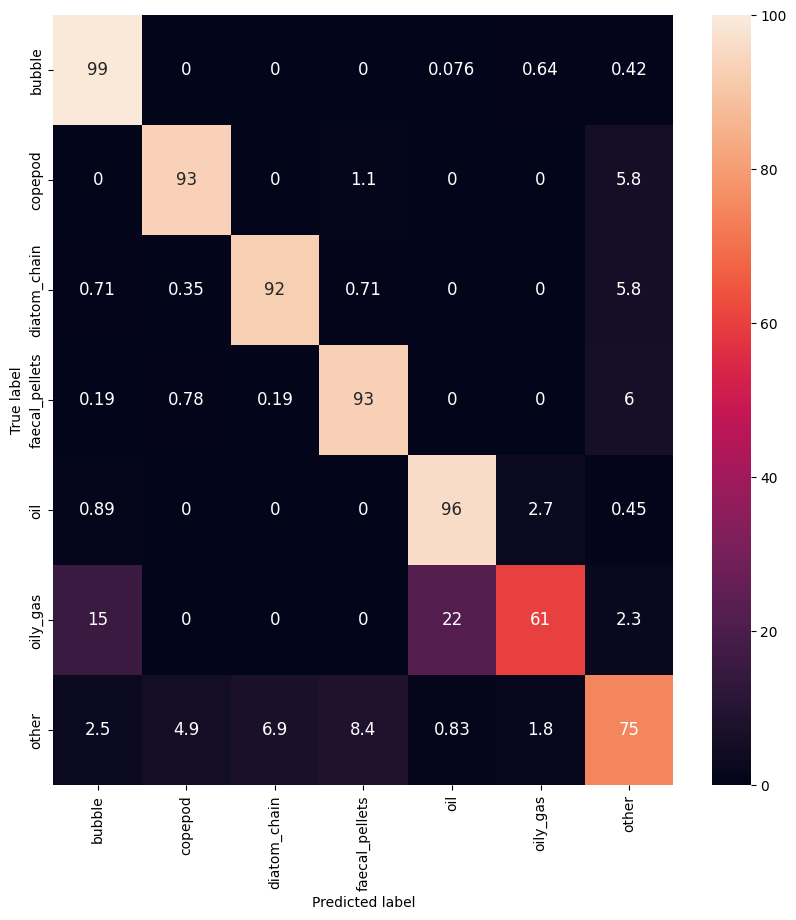

In [7]:
cm = 100 * sklearn.metrics.confusion_matrix(true_categories, ypred, normalize="true")
cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, annot_kws={"size": 12}, vmin=0, vmax=100)  # font size
plt.xlabel("Predicted label")
plt.ylabel("True label")

### Classification report

In [8]:
cl_report = sklearn.metrics.classification_report(true_categories, ypred, target_names=class_labels)
print(cl_report)

                precision    recall  f1-score   support

        bubble       0.95      0.99      0.97      2636
       copepod       0.86      0.93      0.89       657
  diatom_chain       0.85      0.92      0.89       850
faecal_pellets       0.73      0.93      0.82       514
           oil       0.84      0.96      0.90       671
      oily_gas       0.81      0.61      0.69       479
         other       0.91      0.75      0.82      1931

      accuracy                           0.89      7738
     macro avg       0.85      0.87      0.85      7738
  weighted avg       0.89      0.89      0.88      7738



## Classify subset of images from each class and plot each prediction

In [ ]:
for cl in class_imgs.keys():
    filelist = np.random.choice(class_imgs[cl], 15*7)
    classify_plot_class_rois(cl, classifier, class_imgs)

NameError: name 'class_name' is not defined